# Book Cover Recognition with SIFT
_by Giacomo Fantazzini_

## 1. Introduction and description of the problem

I previously collected a labeled dataset of about 4800 pictures of 650 different books for the purpose of neural-network training. All the books are published in Italy and belong mainly to the _"Science Fiction / Cyberpunk"_ subgenre.

Each book in the dataset provides:
1. between 4 and 20 pictures of different instances of the book;
1. its title;
2. its author (or curator, in case of a collection);
3. its _NILF_ code (unique identifier issued by _"Catalogo Vegetti della letteratura fantastica pubblicata in Italia"_).

This set will be used to solve the problem of automatic book recognition by a picture of the cover, possibly extending the task to the recognition of multiple books within the same shot.

The main task seems to be more challenging than just looking for local invariant features because of two issues regarding the dataset:
1. most of the books may have no picture good enough to be used as a sole model;
2. many books published by the same editor share a lot of common misleading graphical features, especially when they are part of the same series.

The dataset and the runnable code for this project work can be retrieved from GitHub: https://github.com/JackFantaz/Book-Cover-Recognition.git

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install opencv-contrib-python==3.4.2.17
!cp -u /content/drive/MyDrive/cv_cloud_playground/nilfdb.zip .
!unzip -nq ./nilfdb.zip

Mounted at /content/drive
     |████████████████████████████████| 30.6 MB 1.3 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [1]:
import random
import math
import time
import os
import datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
%matplotlib inline

The class **Utils** contains several utility functions that will be used throughout the whole project.

In [2]:
class Utils:

    @staticmethod
    def label_image(image, label, info='', label_color='yellow', info_color='yellow'):
        colors={'yellow':((255,255,127)), 'red':(255,63,63), 'green':(63,255,63), 'blue':(63,63,255), 'mono':(224)}
        picture = image.copy()
        if len(picture.shape) >= 3:
            cv2.putText(picture, label, (0,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 6, cv2.LINE_AA)
            cv2.putText(picture, label, (0,30), cv2.FONT_HERSHEY_SIMPLEX, 1, colors[label_color], 2, cv2.LINE_AA)
            cv2.putText(picture, info, (0,60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 6, cv2.LINE_AA)
            cv2.putText(picture, info, (0,60), cv2.FONT_HERSHEY_SIMPLEX, 1, colors[info_color], 2, cv2.LINE_AA)
        else:
            cv2.putText(picture, label, (0,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0), 6, cv2.LINE_AA)
            cv2.putText(picture, label, (0,30), cv2.FONT_HERSHEY_SIMPLEX, 1, colors['mono'], 2, cv2.LINE_AA)
        return picture

    @staticmethod
    def show_images(*pictures, width=12.8, height=7.2):
        plt.figure(figsize=(width, height))
        rows = int(math.floor(math.log2(len(pictures)+1)))
        columns = int(math.ceil(math.sqrt(len(pictures))))
        for i, pic in enumerate(pictures):
            plt.subplot(rows, columns, i+1)
            plt.axis('off')
            if len(pic.shape) >= 3:
                plt.imshow(pic)
            else:
                plt.imshow(pic, cmap='gray')
        plt.show()

    @staticmethod
    def keypoints_map(image, keypoints):
        return cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    @staticmethod
    def elapsed_time(since):
        return datetime.timedelta(seconds=round(time.time()-since))

## 2. Modeling the concept of a book

The class **Book** models the concept of a single image of a book along with its _NILF_ code, title and author. The objects of this class allow the user to seamlessly compute and retrieve the _SIFT_ keypoints of the inherent image and their descriptors.

To speed up development in the early stages of the project, all data coming from storage or in need of pre-processing has been put under _lazy loading_. This way, any error concerning high-level algorithms will show up quickly without delay.

In [3]:
class Book:

    _cards = {}

    def __init__(self, path):
        self._path = path
        self._card = '/'.join(self._path.split('/')[:-1]) + '/card.txt'
        self._image = None
        self._keypoints = None
        self._descriptors = None

    @property
    def image(self):
        if self._image is None:
            self._image = cv2.cvtColor(cv2.imread(self._path), cv2.COLOR_BGR2RGB)
        return self._image

    @property
    def code(self):
        if self._card not in Book._cards:
            with open(self._card, 'r', encoding='ISO-8859-1') as c:
                Book._cards[self._card] = c.read().splitlines()
        return Book._cards[self._card][2]

    @property
    def title(self):
        if self._card not in Book._cards:
            self.code
        return Book._cards[self._card][0]

    @property
    def author(self):
        if self._card not in Book._cards:
            self.code
        return Book._cards[self._card][1]

    @property
    def keypoints(self):
        if self._keypoints is None:
            sift = cv2.xfeatures2d.SIFT_create()
            self._keypoints, self._descriptors = sift.detectAndCompute(self.image, None)
        return self._keypoints

    @property
    def descriptors(self):
        if self._descriptors is None:
            self.keypoints
        return self._descriptors

The class **Model** represents the abstract concept of a book and it is composed of the various **Book** objects acquired as models for the same book. This class provides the raw _SIFT_ keypoints and descriptors (union of all keypoints of the images composing a model) as well as a more refined set of keypoints, selected using two custom-made indicators: **support** and **ambiguity**.

The **support** of a keypoint is the number of times a matching keypoint is found in the other images within the same model, the higher the better. The **ambiguity** of a keypoint is, in turn, the number of times a matching keypoint is found inside a different model, the lower the better.

The computation of the **support**, if not explicitly required, will be skipped to speed up the process. For its calculation, the system will try to perform an homography between each pair of pictures in the model and filter the keypoints based on the results.

The computation of the **ambiguity** is always required and it is done by matching and counting the keypoints individually. The homography is skipped because the keypoints of a model usually come from different pictures and, anyway, to ensure the maximum detection of ambiguous keypoints.

In [4]:
class Model:

    _models = []
    _ambiguity = None
    _flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))

    def __init__(self, books, min_support=0, max_ambiguity=0, _incremental=False):
        self.books = books
        self._min_support = min_support
        self._max_ambiguity = max_ambiguity
        self._raw_keypoints = None
        self._raw_descriptors = None
        self._support = None
        self._keypoints = None
        self._descriptors = None
        if Model._ambiguity is not None and not _incremental:
            Model._models = []
        Model._models.append(self)
        Model._ambiguity = None

    @property
    def code(self):
        return self.books[0].code

    @property
    def sample(self):
        return self.books[0].image

    @property
    def raw_keypoints(self):
        if self._raw_keypoints is None:
            self._raw_keypoints = [k for b in self.books for k in b.keypoints]
        return self._raw_keypoints

    @property
    def raw_descriptors(self):
        if self._raw_descriptors is None:
            self._raw_descriptors = np.array([d for b in self.books for d in b.descriptors])
        return self._raw_descriptors

    @property
    def keypoints(self):
        if self._keypoints is None:
            self._keypoints = []
            self._descriptors = []
            for i, k in enumerate(self.raw_keypoints):
                if self.support(k, _skip=True) >= self._min_support and Model.ambiguity(k) <= self._max_ambiguity:
                    self._keypoints.append(self.raw_keypoints[i])
                    self._descriptors.append(self.raw_descriptors[i])
            self._descriptors = np.array(self._descriptors)
        return self._keypoints

    @property
    def descriptors(self):
        if self._descriptors is None:
            self.keypoints
        return self._descriptors

    def support(self, keypoint, _skip=False):
        if _skip and self._min_support == 0:
            result = 0
        else:
            if self._support is None:
                self._support = {k:0 for k in self.raw_keypoints}
                for b1, b2 in itertools.combinations(self.books, r=2):
                    if len(b1.keypoints) >= 2 and len(b2.keypoints) >= 2:
                        matches = Model._flann.knnMatch(b1.descriptors, b2.descriptors, k=2)
                    else:
                        matches = []
                    good = [m1 for m1, m2 in matches if m1.distance/m2.distance < 0.7]
                    if len(good) >= 4:
                        tb_points = np.float32([b1.keypoints[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
                        mb_points = np.float32([b2.keypoints[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
                        _, mask = cv2.findHomography(mb_points, tb_points, cv2.RANSAC, 5.0)
                        masked = np.ma.masked_array(good, mask=np.logical_not(mask.ravel().tolist())).compressed()
                        for m in masked:
                            self._support[b1.keypoints[m.queryIdx]] += 1
                            self._support[b2.keypoints[m.trainIdx]] += 1
            result = self._support[keypoint]
        return result

    @staticmethod
    def ambiguity(keypoint):
        if Model._ambiguity is None:
            Model._ambiguity = {k:0 for m in Model._models for k in m.raw_keypoints}
            for md1, md2 in itertools.combinations(Model._models, r=2):
                if len(md1.raw_keypoints) >= 2 and len(md2.raw_keypoints) >= 2:
                    matches = Model._flann.knnMatch(md1.raw_descriptors, md2.raw_descriptors, k=2)
                else:
                    matches = []
                good = np.array([mt1 for mt1, mt2 in matches if mt1.distance/mt2.distance < 0.7])
                for m in good:
                    Model._ambiguity[md1.raw_keypoints[m.queryIdx]] += 1
                    Model._ambiguity[md2.raw_keypoints[m.trainIdx]] += 1
        return Model._ambiguity[keypoint]

## 3. Tuning the parameters

The dataset is composed of many small-sized pictures in which the book cover may appear in any pose and with many misleading background objects.

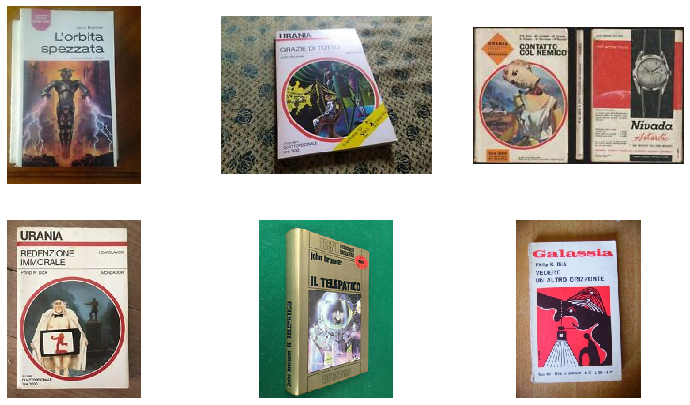

In [16]:
DIRECTORY = 'nilfdb'
directories = ['./{}/{}'.format(DIRECTORY, d) for d in os.listdir('./{}'.format(DIRECTORY))]
books = []
for d in directories:
    files = ['{}/{}'.format(d, f) for f in os.listdir(d)]
    books += [Book(f) for f in files if not 'card.txt' in f]
Utils.show_images(books[644].image, books[351].image, books[513].image, books[1568].image, books[863].image, books[113].image)

The first and simplest strategy to form a model for each book would be to choose the biggest picture available or the picture with the highest number of detectable keypoints. However, these techniques will likely not perform well, since it is not guaranteed for the biggest picture to provide the best cover image or for the picture with the highest number of keypoints to have a non-misleading background.

Since there are at least 4 pictures for each book, it may be convenient to put either 2 or 3 of them in the model and use the **support** and **ambiguity** indicators to get some insight on how to filter their keypoints.

Taking as a model the 3 best pictures (for size or keypoints) of each book may enhance the capabilities of the classifier, however this possibility has been disregarded since taking out multiple best pictures for each book would likely make the test set unreliable. For this reason, the pictures for the models with multiple images have been selected at random.

In [5]:
def max_size_strategy():
    def choice(books, models, targets):
        max_size = -1
        max_book = None
        for b in books:
            size = b.image.shape[0] * b.image.shape[1]
            if size > max_size:
                max_size = size
                max_book = b
        models.append(Model([max_book]))
        targets += [b for b in books if b != max_book]
        return "MAX_SIZE"
    return choice

def max_keypoints_strategy():
    def choice(books, models, targets):
        max_keypoints = -1
        max_book = None
        for b in books:
            keypoints = len(b.keypoints)
            if keypoints > max_keypoints:
                max_keypoints = keypoints
                max_book = b
        models.append(Model([max_book]))
        targets += [b for b in books if b != max_book]
        return "MAX_KEYPOINTS"
    return choice

def random_choice_strategy(model_size=3):
    def choice(books, models, targets):
        target_size = len(books) - model_size
        model_split = books[0:model_size]
        target_split = books[model_size:model_size+target_size]
        models.append(Model(model_split))
        targets += target_split
        return "RANDOM"
    return choice

def split_dataset(strategy=random_choice_strategy(), directory_name='nilfdb', pool_size=30, seed=42, verbose=True):
    random.seed(seed)
    models = []
    targets = []
    directories = ['./{}/{}'.format(directory_name, d) for d in os.listdir('./{}'.format(directory_name))]
    random.shuffle(directories)
    for d in directories[:pool_size]:
        files = ['{}/{}'.format(d, f) for f in os.listdir(d)]
        books = [Book(f) for f in files if not 'card.txt' in f]
        random.shuffle(books)
        name = strategy(books, models, targets)
    random.shuffle(models)
    random.shuffle(targets)
    if verbose:
        print(f"{name}_SPLIT -> seed={seed}", end=", ")
        print(f"models={len(models)}({len([b for m in models for b in m.books])}), targets={len(targets)}")
    return models, targets

def naive_search(target, models):
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    max_count = -1
    max_label = ''
    for m in models:
        for b in m.books:
            if len(target.keypoints) >= 2 and len(b.keypoints) >= 2:
                matches = flann.knnMatch(target.descriptors, b.descriptors, k=2)
            else:
                matches = []
            count = len([m1 for m1, m2 in matches if m1.distance/m2.distance < 0.7])
            if (count > max_count):
                max_count = count
                max_label = b.code
    return max_label, max_count

def naive_test(targets, models, search_algorithm, print_hits=False, print_misses=False):
    since = time.time()
    hits = 0
    misses = 0
    for i, t in enumerate(targets):
        label, matches = search_algorithm(t, models)
        if label == t.code:
            hits += 1
            if print_hits:
                print(f"HIT -> n={i+1}, label={label}, matches={matches}, time={Utils.elapsed_time(since)}")
        else:
            misses += 1
            if print_misses:
                print(f"MISS -> n={i+1}, solution={t.code} guess={label}, matches={matches}, time={Utils.elapsed_time(since)}")
    accuracy = round(hits/(hits+misses)*100, 1)
    print(f"TEST_DONE -> hits={hits}, misses={misses}, accuracy={accuracy}% time={Utils.elapsed_time(since)}")

In [ ]:
seeds = [301, 302]
strategies = [max_size_strategy(), max_keypoints_strategy(), random_choice_strategy(2), random_choice_strategy(3)]
for sd in seeds:
    for st in strategies:
        models, targets = split_dataset(strategy=st, pool_size=100, seed=sd)
        naive_test(targets, models, naive_search)
    print()

MAX_SIZE_SPLIT -> seed=301, models=100(100), targets=614
TEST_DONE -> hits=584, misses=30, accuracy=95.1% time=0:10:29
MAX_KEYPOINTS_SPLIT -> seed=301, models=100(100), targets=614
TEST_DONE -> hits=597, misses=17, accuracy=97.2% time=0:10:42
RANDOM_SPLIT -> seed=301, models=100(200), targets=514
TEST_DONE -> hits=506, misses=8, accuracy=98.4% time=0:15:18
RANDOM_SPLIT -> seed=301, models=100(300), targets=414
TEST_DONE -> hits=409, misses=5, accuracy=98.8% time=0:18:17

MAX_SIZE_SPLIT -> seed=302, models=100(100), targets=633
TEST_DONE -> hits=604, misses=29, accuracy=95.4% time=0:11:54
MAX_KEYPOINTS_SPLIT -> seed=302, models=100(100), targets=633
TEST_DONE -> hits=612, misses=21, accuracy=96.7% time=0:12:03
RANDOM_SPLIT -> seed=302, models=100(200), targets=533
TEST_DONE -> hits=513, misses=20, accuracy=96.2% time=0:16:22
RANDOM_SPLIT -> seed=302, models=100(300), targets=433
TEST_DONE -> hits=422, misses=11, accuracy=97.5% time=0:19:20



The testing shows that, overall, taking 3 pictures for each model brings better results, but at the cost of a significant longer execution time running on a naive search algorithm.

We may now try to tune the minimum **support** required and the maximum **ambiguity** tolerated for a keypoint inside a model to be considered meaningful.

In [17]:
def random_split_dataset(min_support=0, max_ambiguity=0, model_size=3, directory_name='nilfdb',
                         pool_size=-1, seed=42, verbose=True):
    random.seed(seed)
    models = []
    targets = []
    directories = ['./{}/{}'.format(directory_name, d) for d in os.listdir('./{}'.format(directory_name))]
    random.shuffle(directories)
    if pool_size != -1:
        subset = directories[:pool_size]
    else:
        subset = directories
    for d in subset:
        files = ['{}/{}'.format(d, f) for f in os.listdir(d)]
        books = [Book(f) for f in files if not 'card.txt' in f]
        random.shuffle(books)
        target_size = len(books) - model_size
        model_split = books[0:model_size]
        target_split = books[model_size:model_size+target_size]
        models.append(Model(model_split, min_support=min_support, max_ambiguity=max_ambiguity))
        targets += target_split
    random.shuffle(models)
    random.shuffle(targets)
    if verbose:
        print(f"RANDOM_SPLIT -> seed={seed}, min_support={min_support}, max_ambiguity={max_ambiguity}", end=", ")
        print(f"models={len(models)}({len([b for m in models for b in m.books])}), targets={len(targets)}")
    return models, targets

def modelwise_search(target, models):
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    max_count = -1
    max_label = ''
    for m in models:
        if len(target.keypoints) >= 2 and len(m.keypoints) >= 2:
            matches = flann.knnMatch(target.descriptors, m.descriptors, k=2)
        else:
            matches = []
        count = len([m1 for m1, m2 in matches if m1.distance/m2.distance < 0.7])
        if (count > max_count):
            max_count = count
            max_label = m.code
    return max_label, max_count

In [8]:
seeds = [301, 302]
supports = [0,1,2]
ambiguities = [0,1,2]
for sd in seeds:
    for sp in supports:
        for am in ambiguities:
            models, targets = random_split_dataset(min_support=sp, max_ambiguity=am, model_size=3, pool_size=100, seed=sd)
            naive_test(targets, models, modelwise_search, print_hits=False, print_misses=False)
    print()

RANDOM_SPLIT -> seed=301, min_support=0, max_ambiguity=0, models=100(300), targets=424
TEST_DONE -> hits=416, misses=8, accuracy=98.1% time=0:13:10
RANDOM_SPLIT -> seed=301, min_support=0, max_ambiguity=1, models=100(300), targets=424
TEST_DONE -> hits=419, misses=5, accuracy=98.8% time=0:14:06
RANDOM_SPLIT -> seed=301, min_support=0, max_ambiguity=2, models=100(300), targets=424
TEST_DONE -> hits=409, misses=15, accuracy=96.5% time=0:14:31
RANDOM_SPLIT -> seed=301, min_support=1, max_ambiguity=0, models=100(300), targets=424
TEST_DONE -> hits=348, misses=76, accuracy=82.1% time=0:09:06
RANDOM_SPLIT -> seed=301, min_support=1, max_ambiguity=1, models=100(300), targets=424
TEST_DONE -> hits=349, misses=75, accuracy=82.3% time=0:09:20
RANDOM_SPLIT -> seed=301, min_support=1, max_ambiguity=2, models=100(300), targets=424
TEST_DONE -> hits=351, misses=73, accuracy=82.8% time=0:09:18
RANDOM_SPLIT -> seed=301, min_support=2, max_ambiguity=0, models=100(300), targets=424
TEST_DONE -> hits=84,

The testing shows that requiring no minimum **support**, but discarding keypoints with any level of **ambiguity** above zero, provides in most cases a good trade-off between accuracy and efficiency.

Overall, we expect this configuartion to remove from the pool many keypoints associated with the series and the publisher of the book and with common background elements.

RANDOM_SPLIT -> seed=42, min_support=0, max_ambiguity=0, models=100(300), targets=405


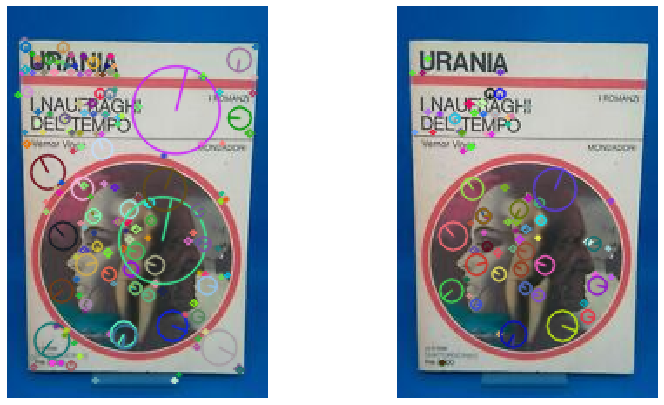

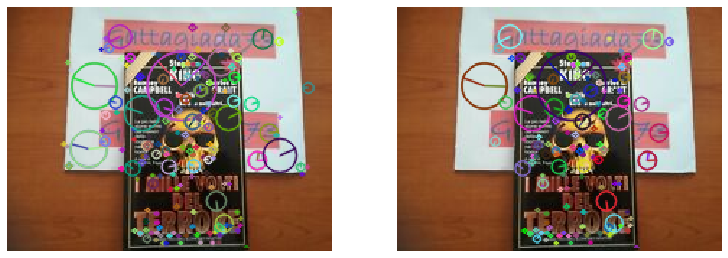

In [45]:
models, _ = random_split_dataset(min_support=0, max_ambiguity=0, model_size=3, pool_size=100)
for i in [87, 54]:
    m = models[i]
    b = m.books[0]
    raw_map = Utils.keypoints_map(b.image, b.keypoints)
    filtered = [k for k in b.keypoints if Model.ambiguity(k)==0]
    filtered_map = Utils.keypoints_map(b.image, filtered)
    Utils.show_images(raw_map, filtered_map)

## 4. A better search algorithm

First of all, it should be noted that the filtering performed on the keypoints does not group matching keypoints inside the same model into a single keypoint. This is the case because two keypoints matching with a third one may not match with each other and, even if that was the case, because it would not be easy or even possible to build a collective description that would match with as many target keypoints as they individually would. The presence of these repeated keypoints has the nice side-effect of giving more weight to the keypoints which have high **support**, and thus which are more reliable.

We may now define a better search algorithm using the filtered keypoints. The full algorithm consists of 3 steps applied to each target-model pair to determine the best matching model for each target:
1. _FLANN_ matching;
2. filter out the keypoints that cannot be made into an homography;
3. if the homography is unsuccessful, filter out just the keypoints with multiple matches.

The choice of the minimum number of matches required to consider the homography valid, within sensible values, should not be critical, since with a very low number of matches for every model, the classification would be pretty much a gamble either with or without the homographies. The chance of overriding a good homography with a bad batch of individual matches should be pretty slim.

Since the filtered keypoints in the model come from a collection of different pictures, the homography step itself would plausibly worsen the performance of the algorithm. Searching for an homography may often lead to the rejection of many good keypoints and to a wrong classification. It is therefore important to include the possibility to skip this step altogether.

In [7]:
def compute_matches(target, model, minimum=4, skip_homography=True, skip_cleaning=False):
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    if len(target.keypoints) >= 2 and len(model.keypoints) >= 2:
        matches = flann.knnMatch(target.descriptors, model.descriptors, k=2)
    else:
        matches = []
    good = [m1 for m1, m2 in matches if m1.distance/m2.distance < 0.7]
    homography = None
    if not skip_homography and len(good) > minimum:
        tb_points = np.float32([target.keypoints[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        mb_points = np.float32([model.keypoints[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        homography, mask = cv2.findHomography(mb_points, tb_points, cv2.RANSAC, 5.0)
        masked = np.ma.masked_array(good, mask=np.logical_not(mask.ravel().tolist())).compressed()
        if len(masked) >= minimum:
            good = masked
        else:
            homography = None
    if not skip_cleaning and homography is None:
        single = list(good)
        for m1, m2 in itertools.combinations(good, r=2):
            if m1.queryIdx == m2.queryIdx or m1.trainIdx == m2.trainIdx:
                if m1 in single:
                    single.remove(m1)
                if m2 in single:
                    single.remove(m2)
        good = np.array(single)
    return good, homography

def smart_search(target, models, skip_homography=True, skip_cleaning=False):
    max_count = -1
    max_label = ''
    for m in models:
        matches, _ = compute_matches(target, m, skip_homography=skip_homography, skip_cleaning=skip_cleaning)
        count = len(matches)
        if (count > max_count):
            max_count = count
            max_label = m.code
    return max_label, max_count

def smart_test(targets, models, skip_homography=True, skip_cleaning=False, print_hits=False, print_misses=False):
    since = time.time()
    hits = 0
    misses = 0
    for i, t in enumerate(targets):
        label, matches = smart_search(t, models, skip_homography, skip_cleaning)
        if label == t.code:
            hits += 1
            if print_hits:
                print(f"HIT -> n={i+1}, label={label}, matches={matches}, time={Utils.elapsed_time(since)}")
        else:
            misses += 1
            if print_misses:
                print(f"MISS -> n={i+1}, solution={t.code} guess={label}, matches={matches}, time={Utils.elapsed_time(since)}")
    accuracy = round(hits/(hits+misses)*100, 1)
    print(f"TEST_DONE -> skip_homography={skip_homography}, skip_cleaning={skip_cleaning}", end=", ")
    print(f"hits={hits}, misses={misses}, accuracy={accuracy}% time={Utils.elapsed_time(since)}")

In [10]:
seeds = [301, 302]
no_homography = [False, True]
no_cleaning = [False, True]
for sd in seeds:
    for nh in no_homography:
        for nc in no_cleaning:
            models, targets = random_split_dataset(model_size=3, pool_size=100, seed=sd)
            smart_test(targets, models, skip_homography=nh, skip_cleaning=nc)
    print()

RANDOM_SPLIT -> seed=301, min_support=0, max_ambiguity=0, models=100(300), targets=424
TEST_DONE -> skip_homography=False, skip_cleaning=False, hits=420, misses=4, accuracy=99.1% time=0:13:21
RANDOM_SPLIT -> seed=301, min_support=0, max_ambiguity=0, models=100(300), targets=424
TEST_DONE -> skip_homography=False, skip_cleaning=True, hits=408, misses=16, accuracy=96.2% time=0:13:20
RANDOM_SPLIT -> seed=301, min_support=0, max_ambiguity=0, models=100(300), targets=424
TEST_DONE -> skip_homography=True, skip_cleaning=False, hits=421, misses=3, accuracy=99.3% time=0:13:15
RANDOM_SPLIT -> seed=301, min_support=0, max_ambiguity=0, models=100(300), targets=424
TEST_DONE -> skip_homography=True, skip_cleaning=True, hits=416, misses=8, accuracy=98.1% time=0:13:13

RANDOM_SPLIT -> seed=302, min_support=0, max_ambiguity=0, models=100(300), targets=439
TEST_DONE -> skip_homography=False, skip_cleaning=False, hits=435, misses=4, accuracy=99.1% time=0:14:05
RANDOM_SPLIT -> seed=302, min_support=0, m

The testing shows that skipping the homography while keeping the removal of multi-matching keypoints brings better results at roughly the same speed as the other strategies. The inclusion of this cleaning step seems to be critical for the accuracy of the algorithm.

Note that the loading of the dataset has been repeated for each test to prevent the computation of **support** and **ambiguity** from slowing down only the first execution, thus hindering the comparison of execution times.

## 5. Finalization and conclusions

We may now compute the models for the whole dataset and perform the filtering before saving them on storage. This way, we avoid repeating the calculation of _SIFT_ keypoints and descriptors and of **support** and **ambiguity** values for each future classification.

In [3]:
def save_models(models, filename='models.pkl', verbose=False):
    register = []
    if verbose:
        for m in models:
            print(f"SAVE -> code={m.code}, kp_length={len(m.keypoints)}, ds_shape={m.descriptors.shape}", end=", ")
            print(f"kp_checksum={round(np.sum([k.pt for k in m.keypoints]))}", end=", ")
            print(f"ds_checksum={np.sum(m.descriptors, dtype=np.int32)}")
    for m in models:
        points = []
        for k in m.keypoints:
            keypoint = (k.pt, k.size, k.angle, k.response, k.octave, k.class_id)
            points.append(keypoint)
        register.append((m.code, points, m.descriptors))
        with open(filename, 'wb') as destination:
            pickle.dump(register, destination)

def load_models(filename='models.pkl', verbose=False):
    with open(filename, 'rb') as source:
        models = []
        register = pickle.load(source)
        for r in register:
            m = dict()
            m['code'] = r[0]
            m['keypoints'] = [cv2.KeyPoint(x=p[0][0], y=p[0][1], _size=p[1], _angle=p[2],
                                           _response=p[3], _octave=p[4], _class_id=p[5]) for p in r[1]]
            m['descriptors'] = r[2]
            models.append(m)
        for m in models:
            if verbose:
                print(f"LOAD -> code={m['code']}, kp_length={len(m['keypoints'])}, ds_shape={m['descriptors'].shape}", end=", ")
                print(f"kp_checksum={round(np.sum([k.pt for k in m['keypoints']]))}", end=", ")
                print(f"ds_checksum={np.sum(m['descriptors'], dtype=np.int32)}")
    return models

In [ ]:
models, targets = random_split_dataset(model_size=3)
save_models(models, filename='/content/drive/MyDrive/cv_cloud_playground/models.pkl', verbose=False)

Finally, we load the models from storage and check them on the whole testing set.

In [9]:
def final_split(model_size=3, directory_name='nilfdb', pool_size=-1, seed=42, verbose=True):
    random.seed(seed)
    models = []
    targets = []
    directories = ['./{}/{}'.format(directory_name, d) for d in os.listdir('./{}'.format(directory_name))]
    random.shuffle(directories)
    if pool_size != -1:
        subset = directories[:pool_size]
    else:
        subset = directories
    for d in subset:
        files = ['{}/{}'.format(d, f) for f in os.listdir(d)]
        books = [Book(f) for f in files if not 'card.txt' in f]
        random.shuffle(books)
        target_size = len(books) - model_size
        model_split = books[0:model_size]
        target_split = books[model_size:model_size+target_size]
        targets += target_split
    random.shuffle(models)
    random.shuffle(targets)
    if verbose:
        print(f"RANDOM_SPLIT -> seed={seed}", end=", ")
        print(f"models={len(models)}({len([b for m in models for b in m.books])}), targets={len(targets)}")
    return targets

def final_matches(target, model):
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    if len(target.keypoints) >= 2 and len(model['keypoints']) >= 2:
        matches = flann.knnMatch(target.descriptors, model['descriptors'], k=2)
    else:
        matches = []
    good = [m1 for m1, m2 in matches if m1.distance/m2.distance < 0.7]
    single = list(good)
    for m1, m2 in itertools.combinations(good, r=2):
        if m1.queryIdx == m2.queryIdx or m1.trainIdx == m2.trainIdx:
            if m1 in single:
                single.remove(m1)
            if m2 in single:
                single.remove(m2)
    return single

def final_search(target, models, skip_homography=True, skip_cleaning=False):
    max_count = -1
    max_label = ''
    for m in models:
        matches = final_matches(target, m)
        count = len(matches)
        if (count > max_count):
            max_count = count
            max_label = m['code']
    return max_label, max_count

def final_test(targets, models, print_hits=False, print_misses=False):
    since = time.time()
    hits = 0
    misses = 0
    for i, t in enumerate(targets):
        label, matches = final_search(t, models)
        if label == t.code:
            hits += 1
            if print_hits:
                print(f"HIT -> n={i+1}, label={label}, matches={matches}, time={Utils.elapsed_time(since)}")
        else:
            misses += 1
            if print_misses:
                print(f"MISS -> n={i+1}, solution={t.code} guess={label}, matches={matches}, time={Utils.elapsed_time(since)}")
    accuracy = round(hits/(hits+misses)*100, 1)
    print(f"TEST_DONE -> hits={hits}, misses={misses}, accuracy={accuracy}% time={Utils.elapsed_time(since)}")

In [ ]:
collection = load_models(filename='/content/drive/MyDrive/cv_cloud_playground/models.pkl', verbose=False)
final_test(targets, collection)

TEST_DONE -> hits=2775, misses=89, accuracy=96.9% time=5:16:19


The final accuracy on the whole dataset is lower than the accuracies reached during the previous tests on smaller samples. This suggests that further tuning and testing, possibly with faster hardware, might be useful.

However, considering the scope of the project and taking into account the partial inadequacy of the dataset, a final accuracy score of about 97% does look good enough and should be able to prove the soundness of this approach.

Now it may be worth focusing a bit on the time required for each individual classification. 

In [10]:
_, targets = random_split_dataset(model_size=3)
models = load_models(filename='/content/drive/MyDrive/cv_cloud_playground/models.pkl')

random.shuffle(targets)
for i, t in enumerate(targets[:10]):
    since = time.time()
    label, _ = final_search(t, models)
    if label == t.code:
        print(f"HIT -> n={i+1}, label={label}, time={Utils.elapsed_time(since)}")
    else:
        print(f"MISS -> n={i+1}, solution={t.code} guess={label}, time={Utils.elapsed_time(since)}")

RANDOM_SPLIT -> seed=42, min_support=0, max_ambiguity=0, models=656(1968), targets=2864
HIT -> n=1, label=NILF101954, time=0:00:09
HIT -> n=2, label=NILF102481, time=0:00:07
HIT -> n=3, label=NILF105754, time=0:00:09
HIT -> n=4, label=NILF103201, time=0:00:08
HIT -> n=5, label=NILF101048, time=0:00:06
HIT -> n=6, label=NILF108388, time=0:00:08
HIT -> n=7, label=NILF109708, time=0:00:07
HIT -> n=8, label=NILF101989, time=0:00:08
HIT -> n=9, label=NILF101051, time=0:00:09
HIT -> n=10, label=NILF108244, time=0:00:07


A time between 7 and 9 seconds spent on each individual classification is probably good enough for a non-industrial application. Consider, for example, a user uploading the picture of a book for the purpose of being redirected to the correct catalogue page (an instance of this use case will be explored in the next section).

## A. Dealing with multiple books within the same shot

As a small appendix, let's see how these models work on 3 custom pictures with more than one book in the same image.

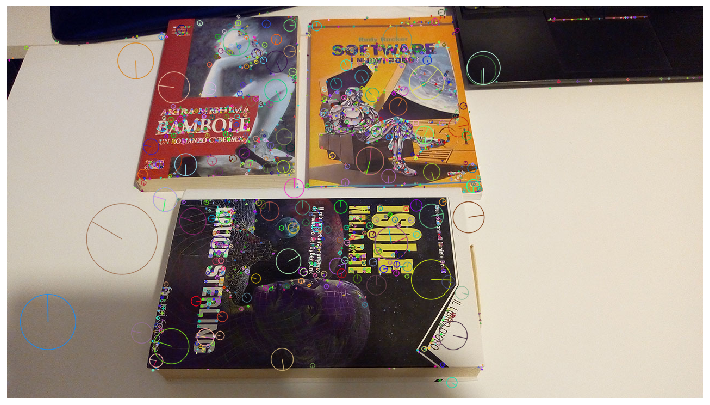

Catalogue pages of the books:	(execution time 0:00:32)
http://nilf.it/108341	(35 matches)
http://nilf.it/108335	(86 matches)
http://nilf.it/107571	(76 matches)


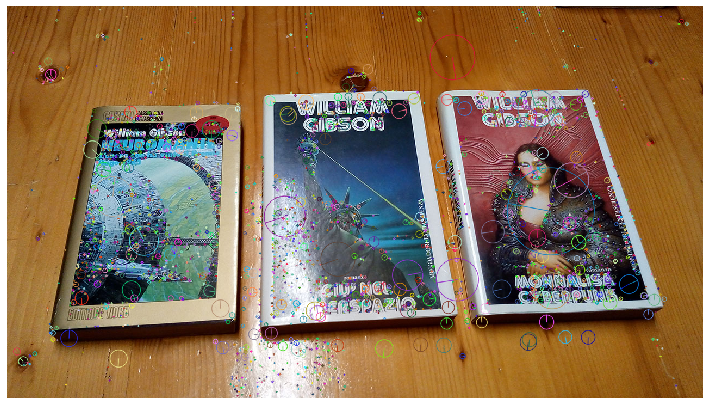

Catalogue pages of the books:	(execution time 0:00:55)
http://nilf.it/105750	(47 matches)
http://nilf.it/113724	(34 matches)
http://nilf.it/104451	(64 matches)
http://nilf.it/105389	(38 matches)


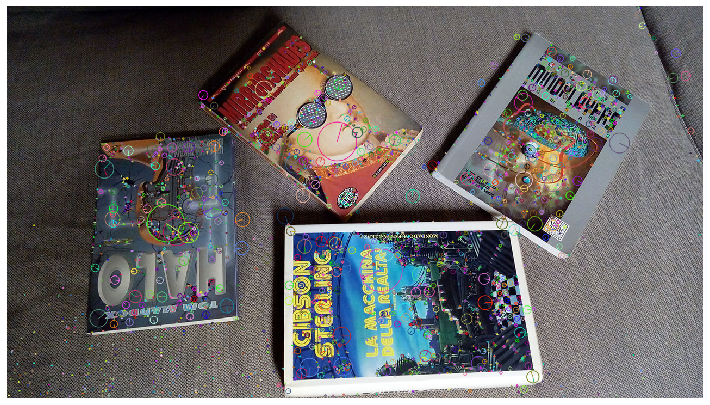

Catalogue pages of the books:	(execution time 0:00:59)
http://nilf.it/106365	(61 matches)
http://nilf.it/108728	(97 matches)
http://nilf.it/107980	(34 matches)
http://nilf.it/108334	(115 matches)


In [15]:
MODELS = 'models.pkl'
TARGETS = 'multishot'

def multiple_search(target, models, threshold=30):
    found = []
    for m in models:
        matches = final_matches(target, m)
        count = len(matches)
        if (count > threshold):
            found.append((m['code'],count))
    return found

models = load_models(filename=MODELS)
targets = [Book('{}/{}'.format(TARGETS, f)) for f in os.listdir('./{}'.format(TARGETS))]
for t in targets:
    since = time.time()
    Utils.show_images(Utils.keypoints_map(t.image, t.keypoints))
    results = multiple_search(t, models)
    print(f"Catalogue pages of the books:\t(execution time {Utils.elapsed_time(since)})")
    for r in results:
        print(f"http://nilf.it/{r[0][4:]}\t({r[1]} matches)")

All the guesses are correct, except for the additional detection of a different edition of a book actually in the shot. Filtering out the overlapping matches before prompting to the user should fix this issue.

The execution times are long because the pictures provided by the user are rather big. It is possible to speed up the process at the cost of some accuracy by shrinking them beforehand.